<a href="https://colab.research.google.com/github/Nosrednum/TesisGisData/blob/main/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline de procesamiento de imagen

### Importación de modulos y librerías

In [ ]:
!pip install landsatxplore
!pip install py7zr
!pip install gdal
!pip install pyshp
!pip install rasterio
!pip install shapely
!pip install geopandas
!pip install earthpy
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install rioxarray

In [ ]:
import os
import gdal
import py7zr
import shutil
import pickle
import tarfile
import zipfile
import urllib3
import rasterio
import shapefile
import matplotlib
import numpy as np 
import cartopy as cp
import earthpy as et
import rasterio as rio
import geopandas as gpd
import landsatxplore.api 
import earthpy.plot as ep
from osgeo import gdal, ogr
import earthpy.spatial as es
from datetime import datetime
from bs4 import BeautifulSoup
from rasterio.plot import show
from rasterio.mask import mask 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from shapely.geometry import mapping
from tensorflow.keras.models import load_model
from landsatxplore.earthexplorer import EarthExplorer
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray as rxr
from matplotlib.colors import ListedColormap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga de la imagen satelital

### carga del api de earth explorer

In [ ]:
#Variables que el usuario va a ingresar como parámetros

#Nombre de usuario y contraseña que corresponden a Earth-Explorer
#https://earthexplorer.usgs.gov/
#Si se requiere un registro, puede registrarse en el siguiente enlace
#https://ers.cr.usgs.gov/register
LANDSATXPLORE_USERNAME = "sd.diazm" 
LANDSATXPLORE_PASSWORD = "|qP5L|ts-e8GTVV" 

#Máxima cobertura de nubocidad que acepta el usuario. 
max_cloud_cover_variable = 30

#Fecha de inicio del rango en el que se desea encontrar la imagen satelital.
start_date_variable = '2020-01-01'
#Fecha de fin del rango en el que se desea encontrar la imagen satelital.
end_date_variable = '2020-11-01'

#Cuadrado del área que se desea que esté incluida dentro de la imagen satelital buscada.
#Esto debe ser ingresado a través de dos puntos que forman un cuadrado ingrados de la siguiente manera
#(latitud_1, longitud_1, latitud_2, longitud_2)
bbox_variable = (4.4447,-75.2934,4.4262,-75.3051)

#Escribir las bandas de interés que el usuario desea. Las bandas deben estar escritas 
#de la siguiente manera: Las bandas del 1 al 9 se escribirán con el prefijo B antes del número
#de la banda. Por ejemplo [B1, B2, B3, B4, B5, B6, B7, B8 ,B9].
#Las bandas del 9 en adelante se escribirán solo con sus dos números. Por ejemplo:
# [ 10 , 11 , 12 , 13 ... ]
#bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B9','10','11']
#bands = ['B1','B2','B3','B4','B5','B6','B7']
bands = ['1' ,'2', '3','4','5','6','7']


#Polígono que se va a obtener de la imágen satelital. La forma de este polígono
# es la que se utilizará para crear el recorte. Esta información debe ser ingresada a través 
# de puntos representados por tuplas de la forma [Longitud, Latitud], se deben ingresar mínimo 
# 3 tuplas de estas, de manera que se pueda formar un polígono.
# Ejemplo : [[Longitud_1, Latitud_1] , [Longitud_2, Latitud_2], [Longitud_3, Latitud_3], .... [Longitud_n, Latitud_n]]
#polygon_variable = [[-74.9834, 4.4568], [-75.0926, 4.4904], [-75.1503, 4.3220], [-74.9950, 4.2775]]
#polygon_variable = [[], [], [], []] 
polygon_variable = [[-75.1466, 4.4820], [-75.2434 ,4.4957], [-75.2661,4.3560], [-75.1719,4.3368]] 




In [ ]:
#Initialize a new API instance and get an acces key
api = landsatxplore.api.API(LANDSATXPLORE_USERNAME, LANDSATXPLORE_PASSWORD)


#Perform a request. Results are returned in a dictionary 
scenes = api.search(
    dataset='LANDSAT_8_C1',
    latitude= 4.4447,
    longitude= -75.2424,
    start_date= start_date_variable,
    end_date= end_date_variable,
    max_cloud_cover = max_cloud_cover_variable,
    bbox = bbox_variable
    )

# Establecer la conexión al API con el usuario y la contraseña habilitados
ee = EarthExplorer(LANDSATXPLORE_USERNAME, LANDSATXPLORE_PASSWORD)

selected_scene = None
min = 100
for scene in scenes:
  if float(scene['cloudCover']) < min:
    selected_scene = scene

#Se muestra el número de escenas encontradas, sin embargo, se escoge aquella
#que tenga la menor nubosidad posible
print('{} scenes found.'.format(len(scenes)))
print(selected_scene)

3 scenes found.
{'acquisitionDate': '2020-08-29', 'startTime': '2020-08-29', 'endTime': '2020-08-29', 'spatialFootprint': {'type': 'Polygon', 'coordinates': [[[-75.48391, 3.6482], [-73.8124, 3.28649], [-73.43979, 5.02523], [-75.11527, 5.38396], [-75.48391, 3.6482]]]}, 'sceneBounds': '-75.48391,3.28649,-73.43979,5.38396', 'browseUrl': 'https://ims.cr.usgs.gov/browse/landsat_8_c1/2020/008/057/LC08_L1TP_008057_20200829_20200905_01_T1.jpg', 'dataAccessUrl': 'https://earthexplorer.usgs.gov/metadata/full/landsat_8_c1/LC80080572020242LGN00/', 'downloadUrl': 'https://earthexplorer.usgs.gov/download/external/options/landsat_8_c1/LC80080572020242LGN00/M2M/', 'entityId': 'LC80080572020242LGN00', 'displayId': 'LC08_L1TP_008057_20200829_20200905_01_T1', 'cloudCover': '27.50', 'metadataUrl': 'https://earthexplorer.usgs.gov/metadata/full/landsat_8_c1/LC80080572020242LGN00/?responseType=viewXml', 'fgdcMetadataUrl': 'https://earthexplorer.usgs.gov/metadata/fgdc/landsat_8_c1/LC80080572020242LGN00/', 'mo

### Descarga de la imagen del api

In [ ]:
directorio_de_salida = '/content/drive/MyDrive/Tesis/rasters'#'./data'
ee.download(scene_id=selected_scene['entityId'], output_dir=directorio_de_salida)
ee.logout()

In [ ]:
with open('/content/drive/MyDrive/Tesis/rasters'+selected_scene + '.tar.gz', 'w') as f:#('/content/data/'+selected_scene + '.tar.gz', 'w') as f:
  f.write('satellite_data.tar.gz')
!cat /content/drive/My\ Drive/foo.txt

### Extracción, lectura y merge de bandas

In [ ]:
#Se extrae el nombre del archivo y se crea el folder en donde se va a 
#desempaquetar su contenido
name_archive = 'LC080090572019090301T1-SC20201130201409'#selected_scene["displayId"]
folder = os.path.join("data", name_archive)
route_targz = os.path.join("/content/drive/MyDrive/Tesis/rasters", name_archive +".tar.gz")
os.makedirs(folder, exist_ok = True)

# Se desempaqueta el contenido del .tar.gz y se dejan las bandas listas en el folder
tar = tarfile.open(route_targz, "r:gz")
tar.extractall(folder)
tar.close()


In [ ]:
#Leer cuáles son las bandas que el usuario desea tener un la imagen multiespectral.
outputPath = 'cliped_data'
inputPath = folder
os.makedirs(outputPath, exist_ok = True)
bandList = [band for band in os.listdir(folder) if band[-4:]== '.tif' and band[-5:-4] in bands]


In [ ]:
bandList.sort( )
#bandList.append(bandList.pop(1))
#bandList.append(bandList.pop(1))
print(bandList)


['LC08_L1TP_009057_20190903_20190917_01_T1_sr_band1.tif', 'LC08_L1TP_009057_20190903_20190917_01_T1_sr_band2.tif', 'LC08_L1TP_009057_20190903_20190917_01_T1_sr_band3.tif', 'LC08_L1TP_009057_20190903_20190917_01_T1_sr_band4.tif', 'LC08_L1TP_009057_20190903_20190917_01_T1_sr_band5.tif', 'LC08_L1TP_009057_20190903_20190917_01_T1_sr_band6.tif', 'LC08_L1TP_009057_20190903_20190917_01_T1_sr_band7.tif']


In [ ]:
#Realizar el merge de las bandas. 

#Leer metadatos del primer archivo 
with rasterio.open("/content/" +folder + "/" +bandList[0]) as src0:
  meta = src0.meta

#Actualziar el meta para reflejar el número de bandas
meta.update( count = len(bandList))

#Leer cada capa y escribirla al stack 
with rasterio.open('multiespectral.TIF' , 'w', **meta) as dst:
  for id, layer in enumerate(bandList , start = 1):
    with rasterio.open("/content/" +folder + "/" + layer) as src1:
      dst.write_band(id,src1.read(1))


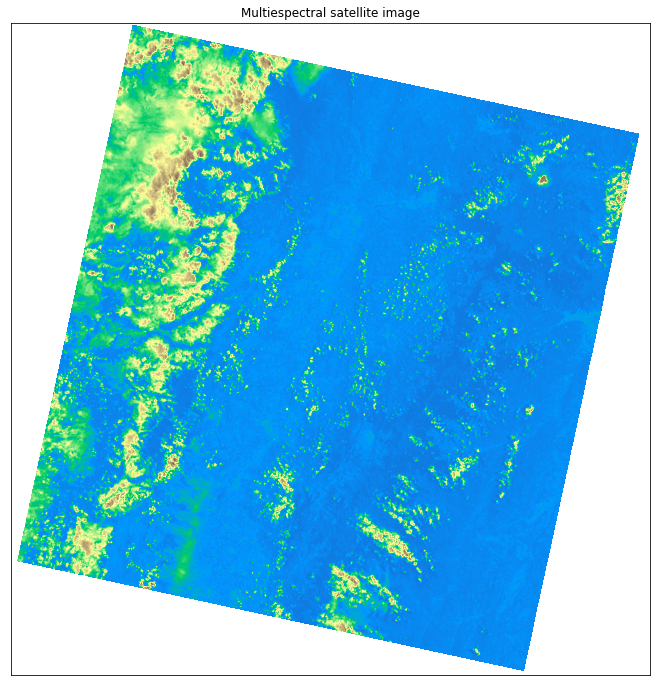

In [ ]:
#Crear la ruta en donde se va a guardar nuestro shape file
shape_file = 'cut_small.shp'
#Ruta del archivo que se va a leer para realizar el clip. 
soap_chm_path = '/content/multiespectral.TIF'


#Abrir el archivo que se va a recortar 
with rio.open(soap_chm_path) as src:
  lidar_chm_im = src.read(masked = True)
  extent = rio.plot.plotting_extent(src)
  soap_profile = src.profile

#Obtener unav ista preeliminar de la imagen satelital a recortar
ep.plot_bands(lidar_chm_im[2],
              cmap='terrain', 
              extent=extent, 
              title = "Multiespectral satellite image",
              cbar=False); 

### transformación de coordenadas del archivo

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 7591, 'height': 7751, 'count': 7, 'crs': CRS.from_epsg(32618), 'transform': Affine(30.0, 0.0, 275385.0,
       0.0, -30.0, 595515.0)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 7588, 'height': 7774, 'count': 7, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00027084870105126323, 0.0, -77.02702607008521,
       0.0, -0.00027084870105126323, 5.387651790045966)}


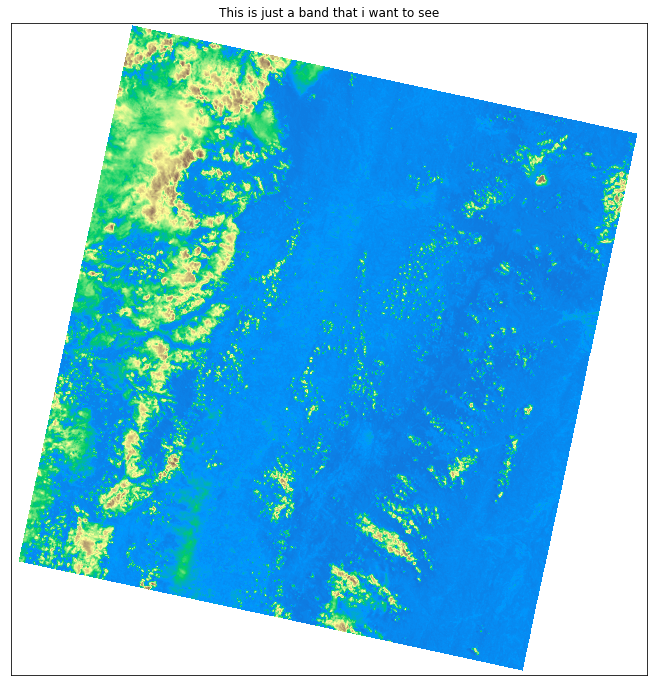

In [ ]:
#Se lee el archivo.TIF multiespectral y se cambia su transformada y sus sistema coordenado
# al sistema EPSG:4326 (WGS84).

#ruta del archivo que se va a transformar y cambiar el sistema coordenado.
soap_chm_path = '/content/multiespectral.TIF'
#Ruta del archivo en donde se va a guardar la iamgen satelital modificada.
multiespectral_transformed = '/content/multiespectral_transformed.TIF'
#Sistema coordenado que se va a aplicar a la imagen satelital.
dst_crs = 'EPSG:4326'


#Abrir el archivo que se va a modificar.
with rasterio.open(soap_chm_path) as src:
    print(src.meta)
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

#Escribir el nuevo archivo tranformado en la ruta indicada.
    with rasterio.open(multiespectral_transformed, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            

#Cargar nuevamente el archivo modificado.
with rio.open(multiespectral_transformed) as src:
  print(src.meta)
  lidar_chm_im = src.read(masked = True)
  extent = rio.plot.plotting_extent(src)
  soap_profile = src.profile


#Vista preeliminar del modelo con el nuevo sistema de coordenadas y la nueva
#trasnformación aplicada.
ep.plot_bands(lidar_chm_im[2],
              cmap='terrain', 
              extent=extent, 
              title = "This is just a band that i want to see",
              cbar=False); 

### Creación del polígono de recorte (.shp)

In [ ]:
#Crear las rutas en donde se van a guardar los archivos necesarios para los polígonos.
polygon_folder = '/content/shapefiles/temp/polygon'
shp_crs_folder = '/content/shapefiles/crsPolygon'
#Crear los directorios
os.makedirs(polygon_folder, exist_ok = True)
os.makedirs(shp_crs_folder, exist_ok = True)

#Crear la instancia de escritura para escribir el polígono.
w = shapefile.Writer(polygon_folder, shapeType=5)
w.field('name', 'C')

#Escribir el polígono.
w.poly([
        polygon_variable #Poly
        ])
w.record('polygon1')
w.close()

#Cargar el shp generado en el paso anterior.
crop_extent_soap = gpd.read_file(polygon_folder+'.shp')
#Dotar del sistema de coorndenadas empleado al neuvo polígono.
crop_extent_soap.crs = 4326
print(crop_extent_soap)
#crop_extent_soap = crop_extent_soap.to_crs(4326)
#Escribir de nuevo el polígono para generar los archivos que se generan 
#Al dotar de un sistema coordado al polígono.
crop_extent_soap.to_file(shp_crs_folder + '/polygon.shp')

#Remover la carpeta temporal en donde se creó el polígono que no tenía
#un sistema coordenado. 
shutil.rmtree('/content/shapefiles/temp', ignore_errors=True)

#Cargar el nuevo polígono con sus sistema coordenado.
crop_extent_soap = gpd.read_file(shp_crs_folder+'/polygon.shp')


       name                                           geometry
0  polygon1  POLYGON ((-75.14660 4.48200, -75.24340 4.49570...


In [ ]:
#Explorar el Coordiante reference system (CRS) de los dos archivos, el polígno y el raster multiespectral.
#Revisar que el sistema coordenado de lso dos archivos coincidad con el mismo CRS
crop_extent_soap = gpd.read_file('/content/shapefiles/crsPolygon/polygon.shp')
#Revisar las coordenadas del polígono.
print(crop_extent_soap)
print('crop extent crs: ', crop_extent_soap.crs)
print('lidar crs: ', soap_profile['crs'])


       name                                           geometry
0  polygon1  POLYGON ((-75.14660 4.48200, -75.17190 4.33680...
crop extent crs:  epsg:4326
lidar crs:  EPSG:4326


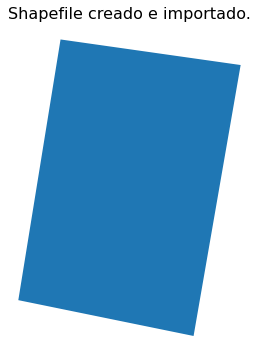

In [ ]:
#Plotear el polígono para observar que coincida con el polígono deseado. 
fig, ax = plt.subplots(figsize= (6,6))
crop_extent_soap.plot(ax=ax)
ax.set_title("Shapefile creado e importado.", fontsize = 16)
ax.set_axis_off()

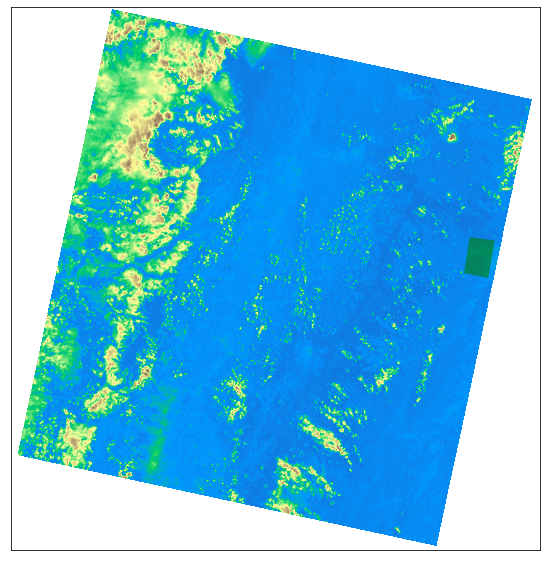

In [ ]:
#Plotear el raster y el polígono, para ver que coincidan en el área que se desea
#recortar del raster. El área demarcada por el polígno es el área que se obtendrá
#del recorte.
fig, ax = plt.subplots(figsize=(10, 10))
ep.plot_bands(lidar_chm_im[2],
              cmap='terrain',
              extent=extent,
              ax=ax,
              cbar=False)
crop_extent_soap.plot(ax=ax, alpha=.6, color='g');

### Corte del shape file

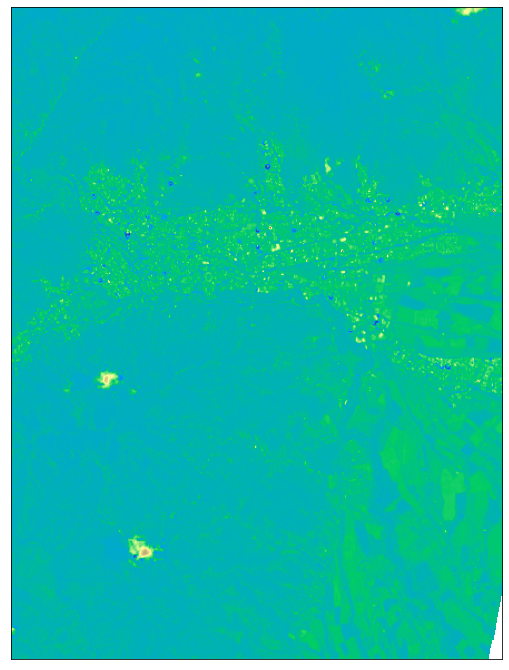

In [ ]:

#Leer la imagen de la imagen multiespectral transformada con el nuevo CRS
#Y luego se procede a recortarla con el shapefile.

with rio.open(multiespectral_transformed) as src:
    lidar_chm_crop, soap_lidar_meta = es.crop_image(src, crop_extent_soap)
# Actualizar los metadatos 
soap_lidar_meta.update({"driver": "GTiff",
                 "height": lidar_chm_crop.shape[1],
                 "width": lidar_chm_crop.shape[2],
                 "transform": soap_lidar_meta["transform"]})

# generar una extensión para el objeto recién recortado 
cr_ext = rio.transform.array_bounds(soap_lidar_meta['height'],
                                            soap_lidar_meta['width'],
                                            soap_lidar_meta['transform'])

bound_order = [0,2,1,3]
cr_extent = [cr_ext[b] for b in bound_order]
cr_extent, crop_extent_soap.total_bounds

#Enmascarar los datos sin datos y trazar la capa ráster recién recortada
lidar_chm_crop_ma = np.ma.masked_equal(lidar_chm_crop[0], -9999.0) 

#Mostrar la imagen del raster recortada. 
ep.plot_bands(lidar_chm_crop_ma, cmap='terrain', cbar=False);

In [ ]:
#Guardar en disco la imagen multiespectral recortada. 
path_out = "/content/multiespectral_clipped.TIF"
with rio.open(path_out, 'w', **soap_lidar_meta) as ff:
    ff.write(lidar_chm_crop)
    
#Limpiar las carpetas y los archivos que no se están utilizando.
#shutil.rmtree("shapefiles", ignore_errors=True)
#shutil.rmtree("data", ignore_errors=True)
#shutil.rmtree("cliped_data", ignore_errors=True)
#shutil.rmtree("/content/multiespectral_clipped.TIF", ignore_errors=True)
#shutil.rmtree("/content/multiespectral_transformed.TIF", ignore_errors=True)


## Procesamiento de la imágen
* carga de la imagen desde `content`
* carga de los modelos entrenados de `drive`
  * selección entre `rf` o `nn` (posible `SVM` futura)
* procesamiento de la imágen con el modelo cargado
* guardado en `content` de el resultado
  * o implementación de visualización directa*




### Carga y creación del modelo

In [ ]:
# Path del modelo preentrenado de red neuronal
model_nn_path = '/content/drive/MyDrive/Tesis/models/nn_model.h5'

# Path del modelo preentrenado de random forest
model_rf_path = '/content/drive/MyDrive/Tesis/models/rf_model_11.pkl'

# metodo que carga el modelo de un archivo
# modelo previamente entrenado
nn_wtch = False
def get_model(model = 'rf'):
  '''
  obtiene un modelo preentrenado para el procesamiento de los datos
  model -> rf: random forest, nn: neural network
  '''
  if model == 'rf':
    nn_wtch = False
    print('loading rf from file')
    with open(model_rf_path, 'rb') as file:
      return pickle.load(file)
  else:
    print('loading nn from file')
    nn_wtch = True
    return load_model(model_nn_path)

### Métodos para carga y guardado de la imágen

In [ ]:
def cargar_imagen(ruta):
    """
    Carga un raster de una imagen satelital en formato .tif y reestructura la imagen en 1-D
    para ser procesada posteriormente por un algoritmo de aprendizaje automatico.
    
    Parameters
        Ruta de localizacion de la imagen

    Return
    --------------
    img_1d: ndarray
        Imagen re-estructurada en una sola dimensión R^2 -> R
    img_array: ndarray
        Imagen con dimensiones originales    
    """

    # Cargar la imagen satelital en la combinacion de bandas de color verdadero (True Image Color)
    imagen_raster = rio.open(ruta)  # abre el archivo tif
    print(imagen_raster.count)

    # Metadatos de la imagen
    print("[Cargar] Metadatos de la imagen en raster:", imagen_raster.meta)

    # Leer el contenido de la imagen y ajustar los pixeles
    imagen_cargada = imagen_raster.read()

    # Cambiar la distribucion de la imagen, leerla en un arreglo Numpy
    img_array = np.empty((imagen_raster.height, imagen_raster.width, imagen_raster.count), imagen_raster.meta['dtype'])
    for band in range(img_array.shape[2]):
      img_array[:, :, band] = imagen_raster.read(band + 1)

    rvi  = img_array[:,:,3]/img_array[:,:,4]
    ndvi = (img_array[:,:,4]-img_array[:,:,3])/(img_array[:,:,4]+img_array[:,:,3])
    evi  = 2*((img_array[:,:,4]-img_array[:,:,3])/(img_array[:,:,4]+6*img_array[:,:,3]-7.5*img_array[:,:,1]+1))
    evi2 = 2*((img_array[:,:,4]-img_array[:,:,3])/(img_array[:,:,4]+2.4*img_array[:,:,5]+1))
    lswi = (img_array[:,:,4]-img_array[:,:,5])/(img_array[:,:,4]+img_array[:,:,5])
    ndvi[ndvi>1]=1
    evi[evi>10000]=10000
    evi2[evi2>10000]=10000
    lswi[lswi>10000]=10000
    ndvi[ndvi<-1]=-1
    evi[evi<-10000]=-10000
    evi2[evi2<-10000]=-10000
    lswi[lswi<-10000]=-10000

    img_array = np.append(img_array, np.atleast_3d(rvi ), axis=2)
    img_array = np.append(img_array, np.atleast_3d(ndvi), axis=2)
    img_array = np.append(img_array, np.atleast_3d(evi ), axis=2)
    img_array = np.append(img_array, np.atleast_3d(evi2), axis=2)
    img_array = np.append(img_array, np.atleast_3d(lswi), axis=2)
    #np.dstack((img_array,img_array[:,:,3]/img_array[:,:,4]))
    
    #df_temp = df_temp[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
    #mat = np.divide(img_array[:,:,3],img_array[:,:,4])
    #np.append(img_array, np.atleast_3d(mat), axis=2)
    #np.append(img_array, img_array[:,:,3]/img_array[:,:,4], axis=1)

    print("[Cargar] Dimension de la Re-estructuracion:", img_array.shape)

    # Estirar las dimensiones X,Y de la imagen en un solo vector para cada una de las bandas espectrales
    img_1d = img_array[:, :, :img_array.shape[2]].reshape((img_array.shape[0] * img_array.shape[1], img_array.shape[2]))
    print("[Cargar] Dimensiones de apilado de la imagen en 1-D", img_1d.shape)

    #img_1d = preprocessing.scale(img_1d)

    return img_1d, img_array, imagen_raster.meta

---
### clasificación de la imágen y ejecución del procesamiento
Método de clasificación de el raster digital
obtiene el modelo, y con este es procesada la imagen previamente pasada por parámetro. Así se obtiene una nueva imágen con la metadata de la original pero con valores de ya procesados para dar las clases necesarias.

#### metodo auxiliar de ploteo de imágenes

In [ ]:
def plot_image(path, image):
  #Abrir el archivo que se va a recortar 
  with rio.open(path) as src:
    lidar_chm_im = src.read(masked = True)
    extent = rio.plot.plotting_extent(src)

  #Obtener una vista preeliminar de la imagen satelital a recortar
  ep.plot_bands(image,
                cmap='terrain', 
                extent=extent, 
                title = "Multiespectral satellite image",
                cbar=False); 

#### metodo principal de clasificación de imagenes

In [ ]:
def clasificar(img_1d, img_array, model_ref = 'nn'):
    model = get_model(model_ref)

    # Transformar la clasificacion de los puntos dada por el cluster en una imagen de 2 dimensiones
    if model_ref == 'nn':
      img_1d = preprocessing.scale(img_1d)
      img_labels = model.predict(img_1d)
      img_labels = np.argmax(img_labels, axis=1) + 1
    else:
      img_labels = model.predict(img_1d)
      
    print("[Clasificación] Dimensiones de la imagen etiquetada pre -> ", img_labels.shape)
    img_labels = img_labels.reshape(img_array[:, :, 0].shape).astype(np.int32)# Transformar de nuevo en las dimensiones X,Y
    print("[Clasificación] Dimensiones de la imagen etiquetada post -> ", img_labels.shape)
    return (img_labels)

In [ ]:
 def guardar_raster(img_labels, img_raster_name, raster_metadata):
    with rio.open(
            '/content/result.TIF',
            'w',
            driver='GTiff',
            height=img_labels.shape[0],
            width=img_labels.shape[1],
            count=1,
            dtype=np.int32,#img_labels.dtype,
            crs=raster_metadata['crs'],
            transform=raster_metadata['transform']
    ) as new_raster:
        new_raster.write(img_labels, 1)

    print(f'[Guardar] Raster GeoTIFF guardado en {img_raster_name}')

#### hilo principal de ejecución, llama a la creación, procesado y guardado de la imágen

In [ ]:
path_out='/content/multiespectral_clipped.TIF'
img_1d, img_array, raster_metadata = cargar_imagen(path_out)# Cargar el raster
img_labels = clasificar(img_1d, img_array, 'nn') # Realizar la clasificación con el modelo cargado
guardar_raster(img_labels, '', raster_metadata) # Guardar el nuevo raster



7
[Cargar] Metadatos de la imagen en raster: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 442, 'height': 587, 'count': 7, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00027084870105126323, 0.0, -75.26623866455095,
       0.0, -0.00027084870105126323, 4.495747017484157)}
[Cargar] Dimension de la Re-estructuracion: (587, 442, 12)
[Cargar] Dimensiones de apilado de la imagen en 1-D (259454, 12)
loading nn from file
[Clasificación] Dimensiones de la imagen etiquetada pre ->  (259454,)
[Clasificación] Dimensiones de la imagen etiquetada post ->  (587, 442)
[Guardar] Raster GeoTIFF guardado en 


In [ ]:
#Análisis exploratorio sobre la imagen a clasificar
with rio.open("/content/multiespectral_clipped.TIF") as src:
  image_EDA = src.read(masked = True)
  extent = rio.plot.plotting_extent(src)
  soap_profile = src.profile

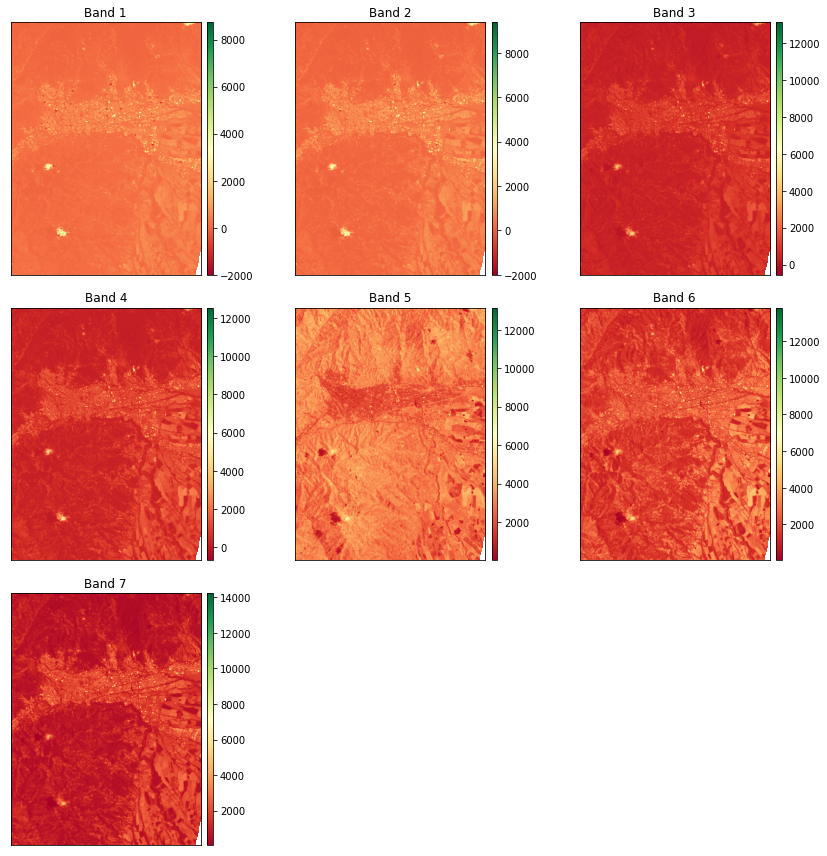

In [ ]:
im = ep.plot_bands(image_EDA, cmap='RdYlGn', figsize=(12,12))
plt.show()

(<Figure size 1800x1800 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c8970dda0>,
       dtype=object))

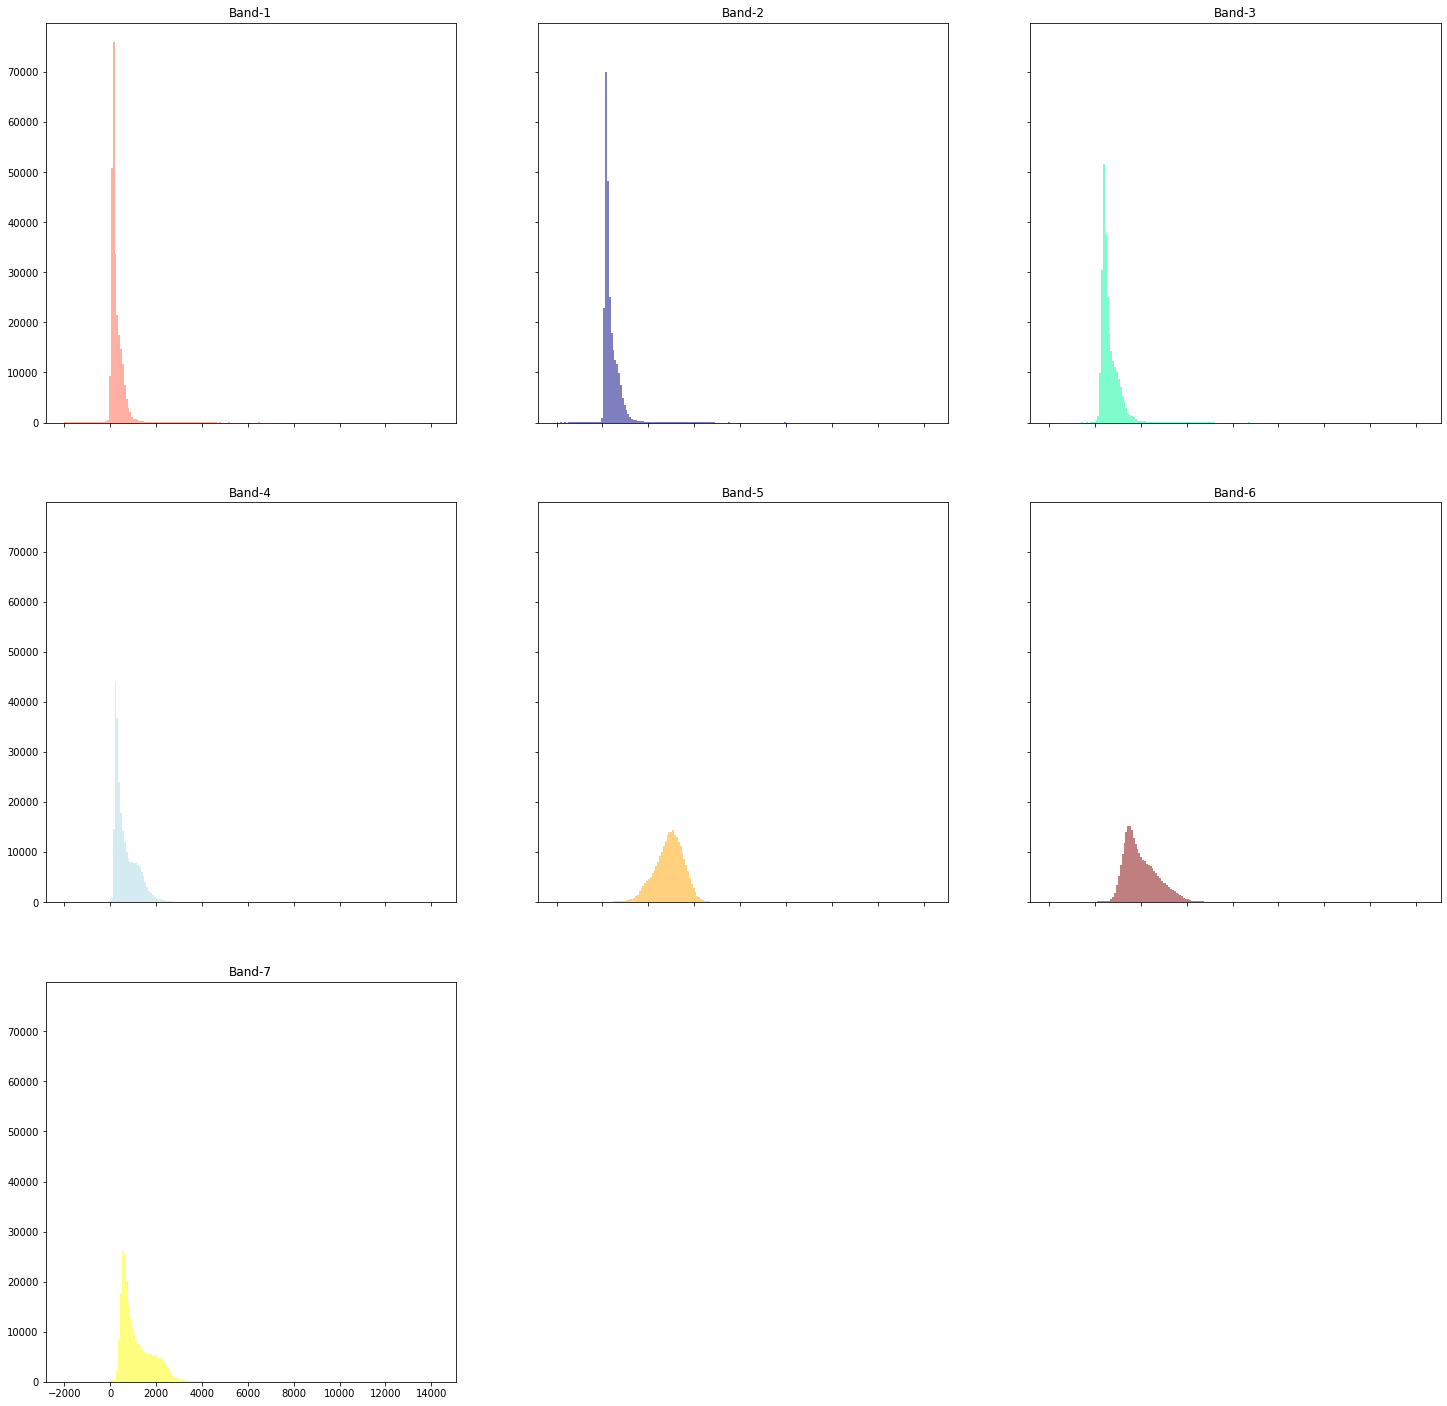

In [ ]:
colors = ['tomato', 'navy','MediumSpringGreen', 'lightblue','orange','maroon','yellow']

ep.hist(image_EDA, colors = colors, title= [f'Band-{i}' for i in range(1,8)], cols=3, alpha=0.5, figsize=(25,25), bins=200)

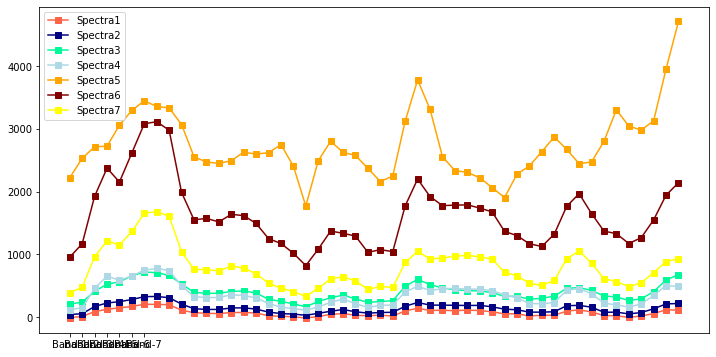

In [ ]:
plt.figure(figsize=(12,6))
for i, c in enumerate(colors):
  plt.plot(np.asarray(img_array[:50,0,i]), '-s', color=c, label=f'Spectra{i+1}')

plt.xticks(range(7), [f'Band-{i}' for i in range(1,8)])
plt.legend()
plt.show()

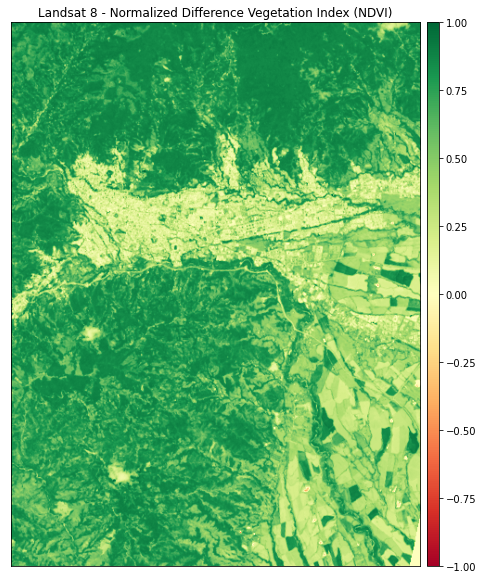

In [ ]:
titles = ["Landsat 8 - Normalized Difference Vegetation Index (NDVI)"]
ep.plot_bands(img_array[:,:,8], cmap='RdYlGn', cols=1, title=titles, vmin=-1, vmax=1, figsize=(10,10))

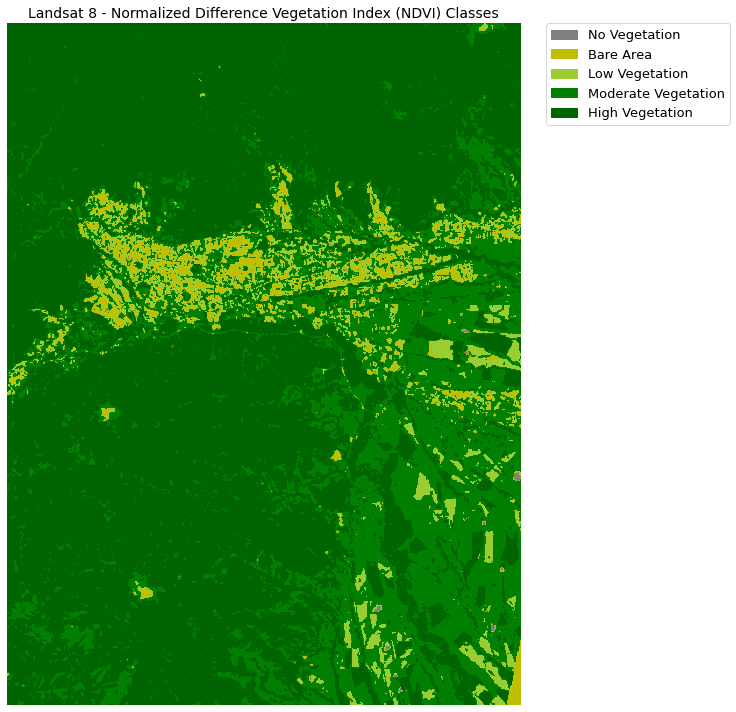

In [ ]:
# Create classes and apply to NDVI results

ndvi = img_array[:,:,8]
ndvi_class_bins = [-np.inf, 0, 0.15, 0.23, 0.6, np.inf]


ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_landsat_class = np.ma.masked_where(np.ma.getmask(ndvi), ndvi_landsat_class)

np.unique(ndvi_landsat_class)

nbr_colors = ["gray", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "No Vegetation",
    "Bare Area",
    "Low Vegetation",
    "Moderate Vegetation",
    "High Vegetation",
]

# Get list of classes
classes = np.unique(ndvi_landsat_class)

classes = classes.tolist()

# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ndvi_landsat_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)

ax.set_title(
    "Landsat 8 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)

ax.set_axis_off()

# Auto adjust subplot to fit figure size

plt.tight_layout()

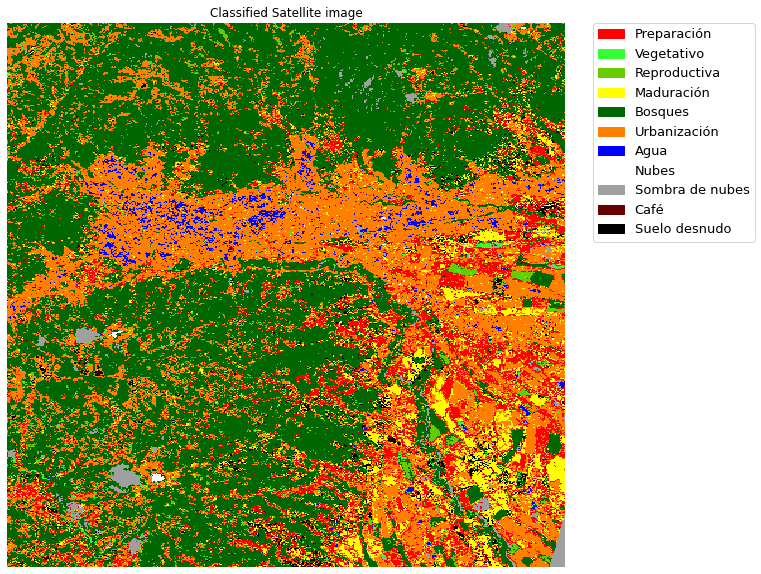

In [ ]:
height_class_labels = ['Preparación', 'Vegetativo', 'Reproductiva', 'Maduración',
                       'Bosques', 'Urbanización', 'Agua','Nubes',
                       'Sombra de nubes','Café','Suelo desnudo'] 
colors = [(1,0,0),(51/255,1,51/255),(102/255,204/255,0),(1,1,0),
          (0,102/255,0),(1,128/255,0),(0,0,1),(1,1,1),
          (160/255,160/255,160/255),(102/255,0,0),(0,0,0)]


#norm = matplotlib.colors.BoundaryNorm(class_bins,len(colors))

cmap = matplotlib.colors.ListedColormap(colors)

pre_lidar_dtm = rxr.open_rasterio('/content/result.TIF', masked=True).squeeze()


# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 10))
im = pre_lidar_dtm.plot.imshow(cmap=cmap, add_colorbar=False)

# Add legend using earthpy
ep.draw_legend(im,titles=height_class_labels)
ax.set(title="Classified Satellite image")
ax.set_axis_off()
plt.show()

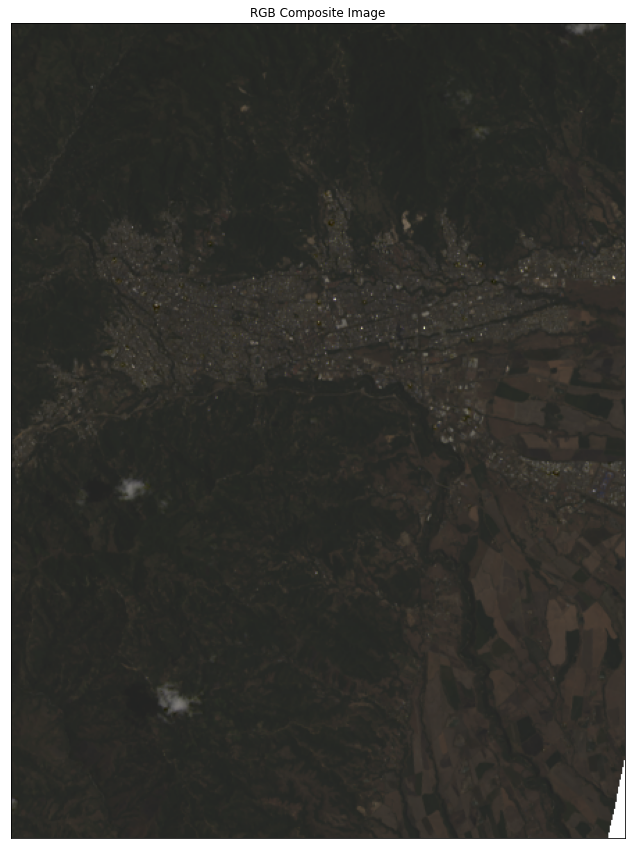

In [ ]:
ep.plot_rgb(image_EDA, rgb=(3,2,1), figsize=(15,15), title='RGB Composite Image') 